BiLSTMVertical:
This is a module that implements a Bidirectional Long Short-Term Memory (BiLSTM) layer with a vertical direction of computation.
It takes two arguments: input_size and hidden_size, which determine the input and hidden state dimensions of the LSTM.
Inside the __init__ method, it initializes an nn.LSTM module with the specified input and hidden sizes. It's set to be bidirectional (bidirectional=True) and accepts input data in batches (batch_first=True).
In the forward method, it applies the BiLSTM to the input tensor x and returns the output.
BiLSTMHorizontal:
This is another module similar to BiLSTMVertical, but it implements a BiLSTM layer with a horizontal direction of computation.
It has the same constructor and forward method structure as BiLSTMVertical.
FullyConnectedLayer:
This module represents a fully connected (linear) layer in a neural network.
It takes two arguments: input_size and output_size, determining the input and output dimensions of the linear layer.
In the __init__ method, it initializes an nn.Linear module with the specified input and output sizes.
In the forward method, it applies the linear transformation to the input tensor x and returns the output.

In [2]:
import torch
import torch.nn as nn

class BiLSTMVertical(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BiLSTMVertical, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)
        
    def forward(self, x):
        output, _ = self.lstm(x)
        return output

class BiLSTMHorizontal(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BiLSTMHorizontal, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)
        
    def forward(self, x):
        output, _ = self.lstm(x)
        return output

class FullyConnectedLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(FullyConnectedLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        output = self.fc(x)
        return output



Sequencer2D
Is a sequencer in which the input data (images) are splitted into vertical adn horiziontal component, then vertical data will be passed as input to BilstmVertical ,while horizontal_data will be passed to BiLSTMHorizontal, to do so the input data are first processed in such a way we'll have a tensor with vertical data of each image and another tensor with horizontal data of each image. Oncee we get the outputs from both BiLSTMvertical and BiLSTMHorizontal, we 'll concatenate them and pass as input the result to Fully Connected Layer . At the end of the sequencer the results will be a list of tensor ( each tensor has inside data belongs to each image processed above)

In [3]:


class Sequencer2D(nn.Module):
    def __init__(self, input_size, hidden_size, mlp_input_size, mlp_output_size):
        super(Sequencer2D, self).__init__()

        # Create instances of the defined models
        vertical_bilstm = BiLSTMVertical(input_size, hidden_size)
        horizontal_bilstm = BiLSTMHorizontal(input_size, hidden_size)
        fully_connected = FullyConnectedLayer( mlp_input_size,mlp_output_size)  

        # Move models to GPU if available
        #vertical_bilstm.to(device)
        #horizontal_bilstm.to(device)
        #fully_connected.to(device)

        self.vertical_bilstm = vertical_bilstm
        self.horizontal_bilstm = horizontal_bilstm
        self.fully_connected = fully_connected

    def forward(self, x):
        if isinstance(x, list):
            x = torch.stack(x)
        if len(x.shape)==4:
            batch_size,channel, height, width = x.size()
            x=x.squeeze(1)
        elif len(x.shape) == 3 :
            batch_size, height, width = x.size()
        output=[]
        for index in range(batch_size):
            x_vertical = x[index][:, :height//2]  #split the image vertically
            x_horizontal = x[index][ :,width//2:]   #split image horizontally

            vertical_data = x_vertical.permute( 1,0) #permutation to fit bilstm
            horizontal_data = x_horizontal.permute( 1,0)#same here
            
            
            
            H_ver = self.vertical_bilstm(vertical_data)
            H_hor = self.horizontal_bilstm(horizontal_data)
            
            
            H_ver = torch.tensor(H_ver, dtype=torch.float32).permute(1,0) #permute to fit torch.cat
            H_hor = torch.tensor(H_hor, dtype=torch.float32).permute(1,0)
            
           
            
            
            H_concat = torch.cat((H_ver, H_hor), dim=1)#concatenaiton of the horizontal and vertical bilstm outputs
            H_concat = H_concat.unsqueeze(0) #set dimension to fit fully conncted layer

            
            
            
            #fully connected layer
            
            
            output_pieces = self.fully_connected(H_concat)
            
            output_pieces=torch.tensor(output_pieces, dtype=torch.float32)
            output.append(output_pieces) #add output to lists of each image data processed here
        
        return output


Patch Embedding : this costum function given an image , a patch size, will splitted the image in image_size/patch_size pieces.

image_size: The size of the input image. It represents both the height and width of the image.
patch_size: The size of each non-overlapping patch that the image is divided into.
in_channels: The number of input channels in the image. For RGB images, this is typically 3 (for the red, green, and blue channels).
embed_dim: The dimension of the embedded representations for each patch.


In [4]:


class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_dim = embed_dim

        
        self.num_patches = (image_size // patch_size) ** 2 #compute the number of patches in such a way they won't overlap

        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size) #convolutional layer takes the input image, divides it into patches, and embeds each patch into a lower-dimensional representation.

    def forward(self, x):
        # input x should have the shape (B, C, H, W) if needed: B, C, H, W = x.shape
     
        x = self.projection(x).flatten(2).transpose(1, 2)  # (B reshape the input to split it into patches

        return x
    def output_dimension(self):
        return self.embed_dim * self.num_patches


PW Linear Layer compute  pointwise linear transformations on a list of input tensors.

In [5]:
class PWLinearLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(PWLinearLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, input_list):
        output_list = []
        for input_tensor in input_list:
            output_tensor = self.linear(input_tensor)
            output_list.append(output_tensor)
        stacked_output = torch.stack(output_list, dim=0)
        return stacked_output


Patch merging, take the images splitted in patches (for examples by patch embedding ) and merge it together, the number of patches merged is based on the output channlee and  the  scale factor number.

In [6]:
class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor):
        super(PatchMerging, self).__init__()
        self.scale_factor = scale_factor
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, patch_list):
        
        x = torch.cat(patch_list, dim=1).permute(1,2,0) # compination of the list of patches into a single tensor + peermutation to fit convolutional layer
        
        
        x = self.conv(x) # Apply to the input x, a 1x1 convolution to merge the patches together
        
        
        x = nn.functional.interpolate(x, scale_factor=self.scale_factor, mode='nearest') #resize the feature map using a nearest-neighbor upsampling

        return x


In [91]:


class GlobalAveragePooling(nn.Module):
    def __init__(self):
        super(GlobalAveragePooling, self).__init__()

    def forward(self, x):
        
        x = torch.mean(x, dim=(-2, -1))# perform global average pooling along spatial dimensions using the mean
        return x


Feedforward network not used in this code 

In [8]:
# WARNING: This is the Feedforward Neural Network (FFN), I've tried to add this to the model but it slow the process too much
class FFN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, activation=nn.GELU()):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.activation = activation

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x) #aI've tried other activ.fucntion before decided to apply GELU function () in the original code they use Gelu activation function too )
        x = self.fc2(x)
        return x


Sequencer2Dmodel-> Is an architecture that resambles vision transformer except for the fact that Sequencer2D model is using BiLSTM2D (splitting image in horizzontal and vertical data) instead of self attention. It started with patch embedding layeer so the images will be divided in 8x8 patches, than ,after a normalization, there is the first sequence block of 4 Sequencer , the output of this block converge in PatchMerging, where the patches are resembled together ,then there is a second sequencer block made of 3 sequencer2d, followed by pointwise linear layer,then other sequencer block with 8 sequencers2D, then other point wise linear layer and  the final sequencerBlock with 3 sequencer2D layer and at the end there are linears+ global avarage pooling layers in order to make the output dimension as expected-

The parameters are the one suggested by the paper

In [70]:

class Sequencer2DModel(nn.Module):
    def __init__(self, num_classes, in_channels):
        super(Sequencer2DModel, self).__init__()

        self.num_classes = num_classes
        

       
        self.patch_embedding_1 = PatchEmbedding(16, 8, in_channels,64 ) #  patch embedding with an 8x8 kernel size for each patch
        self.ln_1 = nn.LayerNorm(64)

       
        self.sequencer_block_1 =  nn.Sequential(
            Sequencer2D(16, 48, 40, 96),
            Sequencer2D(96, 96, 96, 192),
            Sequencer2D(192, 192, 192,384),
            Sequencer2D(384, 192, 384,384)
        )

        
        self.patch_merging=PatchMerging(24576,64,2)
        

        
        self.sequencer_block_2 =  nn.Sequential(
            Sequencer2D(384, 192, 3,384),
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384)
        )

        
        self.pw_linear_1 = PWLinearLayer( 384,384)
        
        
        self.sequencer_block_3 =  nn.Sequential(
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384),
            
            
           
        )



        # Feedforward Neural Network remove comments to use 
        #self.ffn = nn.Sequential(
        #    nn.Linear(384,384),
        #    nn.ReLU(),
        #    nn.Linear(1024, 512),
        #    nn.ReLU(),
        #    nn.Linear(512, 256),
        #)
        
        self.pw_linear_2 = PWLinearLayer(384, 384)

        
        self.sequencer_block_4 =  nn.Sequential(
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384)
        )
        self.pw_linear_3 = PWLinearLayer(384, 384)



        
        self.ln_2 = nn.LayerNorm(384)

        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 384))

        
        self.fc = nn.Linear(384, num_classes)
        
        
        

    def forward(self, x):
       
        
        x = x.to(torch.float32).permute(0,3,1,2)  # convert input tensor to float32 + permutation to fit patch embedding 
        x = self.patch_embedding_1(x)
        x = self.ln_1(x) #linearization

        
        x = self.sequencer_block_1(x)

        
        x = self.patch_merging(x) #merging patches of images processed in bilstm
        
        
        
        x = self.sequencer_block_2(x)
        x = self.pw_linear_2(x)
        
        x = self.sequencer_block_3(x)

        
        # here should be the place for feedforward NN
        #x = self.ffn(x)

        # soem addditional Linear Layers after FNN 
        #x = self.fc1(x)
        #x = self.fc2(x)
        
        
        x = self.pw_linear_2(x)

        
        x = self.sequencer_block_4(x)
        x = self.pw_linear_3(x)
        
        
        x = self.ln_2(x)
        
        x = self.global_avg_pool(x)#apply global avg pooling 
        
        x = self.fc(x)#final linear layer that brings the output in the desired shape


        

        return x



CustomCifar2, this custom function process imace into the dataset in order to take only the first two classes.

In [10]:
from torchvision import datasets
import numpy as np
from torch.utils.data import Dataset

class CustomCIFAR2(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(CustomCIFAR2, self).__init__()
        self.cifar10 = datasets.CIFAR10(root, train=train, transform=transform, target_transform=target_transform, download=download)
        
        
        self.keep_classes = [0, 1]  # Class indices for airplane and automobile

        
        self.data, self.targets = self.filter_classes()#will filtered all the data in order to keep only the classes specified

    def filter_classes(self):
        mask = np.isin(self.cifar10.targets, self.keep_classes)
        data = [self.cifar10.data[i] for i, include in enumerate(mask) if include]
        targets = [self.cifar10.targets[i] for i, include in enumerate(mask) if include]
        return data, targets

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        return img, target

    def __len__(self):
        return len(self.data)


In [71]:
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
image_size = 32
patch_size = 8
model = Sequencer2DModel(num_classes=2, in_channels=3)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


batch_size = 64 # obv if batch_size changes, it must be changed the parameters of sequencer Model.

num_epochs = 10

#This part includes transformations applied to the data,so preprocessing +data augmentation.
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),   # Randomly flip the image horizontally
    transforms.RandomRotation(15),      # Randomly rotate the image by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.8),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),# Adjust brightness, contrast, saturation, and hue
    transforms.RandomResizedCrop(16),
    transforms.RandomResizedCrop(4),# Randomly crop and resize the image to 224x224
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomAffine(degrees=4, translate=(0.4, 0.1)),# Randomly translate the image
    transforms.ToTensor(),              # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image

])


#remove comment "#" below to use all classes, instead of 2 as used in this data_loader
#train_dataset = torchvision.datasets.CIFAR10(root='/Users/stellafazioli/Downloads/cifar-10-batches-py', train=True, transform=transform)
custom_dataset = CustomCIFAR2(root='/Users/stellafazioli/Downloads/cifar-10-batches-py', train=True, transform=transform, download=True)
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)#calls the custom dataset that has charged only the first 2 classes from the dataset

Files already downloaded and verified


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #to use GPU
model.to(device) #save model to device
all_labels=[]
all_accuracy=[]
all_loss=[]

# Start the training Phase
for epoch in range(num_epochs):
    total_correct = 0 #total number of right prediction 
    total_samples = 0 #total number of image processed
    running_loss = 0.0 # take the count of loss during 100 batches

    for i, data in enumerate(data_loader, 0):
        if i==156:  #in order to jump 
            continue
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        
        optimizer.zero_grad()
        
        
        outputs = model(inputs)# does forward pass by feed the model
        
        outputs=outputs.view(64,2)# reshape outputs
        
        
        predicted_probabilities = torch.sigmoid(outputs) #tensor of prediciton over outputs using sigmoid function
        
        loss = criterion(predicted_probabilities[:,0], labels.float()) #compute loss (Binary crossEntropy function)
        
        all_loss.append(loss)
        
        loss.backward()#does backpropagation
        optimizer.step()# call optimizer (Adam )

        
        running_loss += loss.item() 
        predicted_probabilities = outputs.argmax(dim=1) #reshape to compute correct prediction
        correct = (predicted_probabilities == labels).sum().item() #compute the sum of all the prediction that are equal to labels so the  sum of all the right prediction
        total_correct += correct #total correct predition over all epochs untill now
        total_samples += labels.size(0) #total number of images trained over all epochs
        
        batch_accuracy = (correct / labels.size(0)) * 100.0 #compute accuracy percentage 
        batch_accuracy = (correct / labels.size(0)) * 100.0
        all_accuracy.append(batch_accuracy)
        for label in labels:
            all_labels.append(labels)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(data_loader)}] Loss: {loss.item():.4f} Accuracy: {batch_accuracy:.2f}%")
        if i % 100==0 :  # Print every 100 mini-batches
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(data_loader)}] Loss: {loss.item():.4f} Accuracy: {batch_accuracy:.2f}%")
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

    epoch_accuracy = (total_correct / total_samples) * 100.0
    print(f"Epoch [{epoch+1}/{num_epochs}] Accuracy: {epoch_accuracy:.2f}%")

print("Finished Training")


In [92]:
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import pickle

model_pkl_file = "sequencer_model384S_binary.pkl"

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)

In [84]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),   
    transforms.RandomRotation(15),     
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    
    transforms.RandomResizedCrop(16),
    transforms.RandomResizedCrop(4),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomAffine(degrees=4, translate=(0.4, 0.1)),
    transforms.ToTensor(),              
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  

])


test_dataset = CustomCIFAR2(root='/Users/stellafazioli/Downloads/cifar-10-batches-py', train=False, transform=transform, download=True)#load cifar10 test images with custom function for dataset in order to charge only 2 classes
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)#load the test data


# remove comment and change the file name with the path of the model in case it is needed 
# model.load_state_dict(torch.load('your_model_weights.pkl'))

# Set your device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model in evaluation mode (disables dropout and batch normalization)
model.eval()

# Lists to store predictions and ground truth labels
all_predictions = []
all_labels = []
all_loss=[]
all_accuracy=[]
c=0
# Iterate through the test dataset and make predictions
total_correct=0
total_samples=0
with torch.no_grad():
    for inputs, labels in test_loader:
        
        c+=1
        print(c)
        if c==78:
            continue
        inputs, labels = inputs.to(device), labels.to(device)
       
        # Forward pass
        outputs = model(inputs)

        # Calculate predicted labels (you may need to adjust this part based on your model)
        # Assuming the model's output is a tensor of shape (batch_size, num_classes)
        #predicted_labels = torch.argmax(outputs, dim=1)

       
        lab_seq=torch.stack(lab_seq)
        all_labels.extend(lab_seq.cpu().numpy())
        
        predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
        predicted_labels = predicted_labels.argmax(dim=1)
        predicted_labels= predicted_labels.argmax(dim=1)
        
        
        
        correct = (predicted_labels[:,0] == labels).sum().item()
        
        total_correct += correct
        total_samples += lab_seq.size(0)
        
        accuracy = (total_correct / total_samples) * 100.0  
        print(f"batch: [{i}/{len(data_loader)}]",f"Test Accuracy: {accuracy :.2f}%")
# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Files already downloaded and verified
1


<ipython-input-3-3fb609d5316e>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H_ver = torch.tensor(H_ver, dtype=torch.float32).permute(1,0)
<ipython-input-3-3fb609d5316e>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H_hor = torch.tensor(H_hor, dtype=torch.float32).permute(1,0)
<ipython-input-3-3fb609d5316e>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_pieces=torch.tensor(output_pieces, dtype=torch.float32)


torch.Size([64, 384, 2])
torch.Size([64, 1, 1, 384])
batch: [115/157] Test Accuracy: 29.69%
2
torch.Size([64, 384, 2])
torch.Size([64, 1, 1, 384])


TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

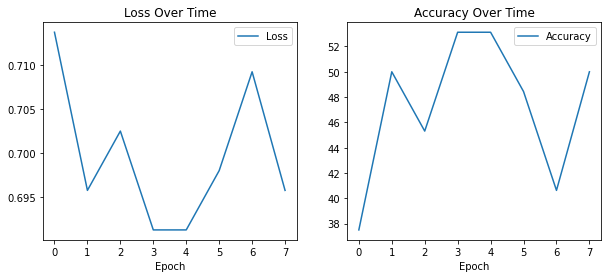

In [90]:

import matplotlib.pyplot as plt
all_loss=torch.tensor(all_loss)
# this code will plot loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(all_loss.detach().numpy(), label='Loss')
plt.xlabel('Epoch')
plt.title('Loss Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(all_accuracy, label='Accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy Over Time')
plt.legend()

plt.show()